## Estruturando Modelos
#### Imports

In [1]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np

import sklearn as sk
import matplotlib as mt
import sys

In [2]:
print("Python:  ", sys.version)
print("Pandas:  ", pd.__version__)
print("Numpy:   ", np.__version__)
print("Matplt:  ", mt.__version__)
print("Sklearn: ", sk.__version__)

Python:   3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
Pandas:   2.0.0
Numpy:    1.23.5
Matplt:   3.7.1
Sklearn:  1.2.2


#### Definição Padrão

In [3]:
dataName = "PETR4_B_0_30min"
ensemble = "Ensemble_Classificação"

### Incluindo os dados

In [4]:
X_train = pd.read_csv(f'../../Data/Selected/dataset1/X_Train_{dataName}.csv', sep=";")
X_test  = pd.read_csv(f'../../Data/Selected/dataset1/X_Test_{dataName}.csv' , sep=";")
Y_train = pd.read_csv(f'../../Data/Selected/dataset1/Y_Train_{dataName}.csv', sep=";")['OutPut_class |T+1|']
Y_test  = pd.read_csv(f'../../Data/Selected/dataset1/Y_Test_{dataName}.csv' , sep=";")['OutPut_class |T+1|']
Y_testV = pd.read_csv(f'../../Data/Selected/dataset1/Y_Test_{dataName}.csv' , sep=";")['OutPut |T+1|']

display(X_train.head(2))
display(X_test.head(2))
display(Y_train.head(2))
display(Y_test.head(2))
display(Y_testV.head(2))

,ADX_14,Fechamento_MACD_12:26,Fechamento_MACD_8:17,Fechamento_MTM_10
0,0.262475,0.136769,0.138766,4.703974
1,0.237859,0.155631,0.155152,4.792851


,ADX_14,Fechamento_MACD_12:26,Fechamento_MACD_8:17,Fechamento_MTM_10
0,0.067427,-0.010945,0.010853,0.666667
1,0.061722,-0.007905,0.011660,0.665927


0    0
1    1
Name: OutPut_class |T+1|, dtype: int64

0    1
1    1
Name: OutPut_class |T+1|, dtype: int64

0    9.07
1    9.07
Name: OutPut |T+1|, dtype: float64

#### Models

In [5]:
models = []
namesM = ['SVM', 'KNN', 'LR', ensemble]
models.append(SVC(kernel='rbf'))                 # SVM (SVC) Support Vector Machine
models.append(KNeighborsClassifier())            # KNN K Neighbors Classifier
models.append(LogisticRegression())              # LR Logistic Regression

#### Executando Modelos

In [6]:
for model in models:
    model.fit(X_train.values, Y_train.values)

### Analisando Modelos Individuais

In [7]:
res = pd.DataFrame({})
for i in range(len(models)):
    Y_pred = models[i].predict(X_test.values)    
    res = pd.concat([res, pd.DataFrame({namesM[i]:Y_pred})], axis=1)
    
display(res.head(5))

,SVM,KNN,LR
0,1,0,1
1,1,0,1
2,1,0,1
3,1,0,1
4,1,1,1


### Modelo de Predição Ensamble (Hard Voting)

In [8]:
hardVoting = res.mode(axis=1)[0]
res = pd.concat([res, pd.DataFrame({ensemble:hardVoting})], axis=1)
display(res.head(3))

,SVM,KNN,LR,Ensemble_Classificação
0,1,0,1,1
1,1,0,1,1
2,1,0,1,1


### Analise dos Resultados (Estatística)

In [9]:
for i in range(res.shape[1]):
    print(f'********* Modelo {namesM[i]} *********',
          "\nAcurácia: ", accuracy_score(Y_test, res[namesM[i]]),
          "\nF1-score: ", f1_score(Y_test, res[namesM[i]]),
          "\nMatriz Confusão: \n", confusion_matrix(Y_test, res[namesM[i]]), "\n\n")

********* Modelo SVM ********* 
Acurácia:  0.5643732970027248 
F1-score:  0.7215327672545176 
Matriz Confusão: 
 [[   0 1279]
 [   0 1657]] 


********* Modelo KNN ********* 
Acurácia:  0.5071525885558583 
F1-score:  0.5881013378878451 
Matriz Confusão: 
 [[ 456  823]
 [ 624 1033]] 


********* Modelo LR ********* 
Acurácia:  0.5616485013623979 
F1-score:  0.7180722891566265 
Matriz Confusão: 
 [[  10 1269]
 [  18 1639]] 


********* Modelo Ensemble_Classificação ********* 
Acurácia:  0.5636920980926431 
F1-score:  0.7206106870229008 
Matriz Confusão: 
 [[   3 1276]
 [   5 1652]] 




### Analise dos Resultados (Econometria)

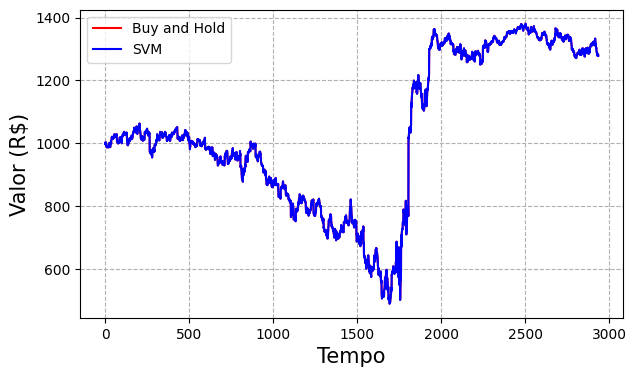

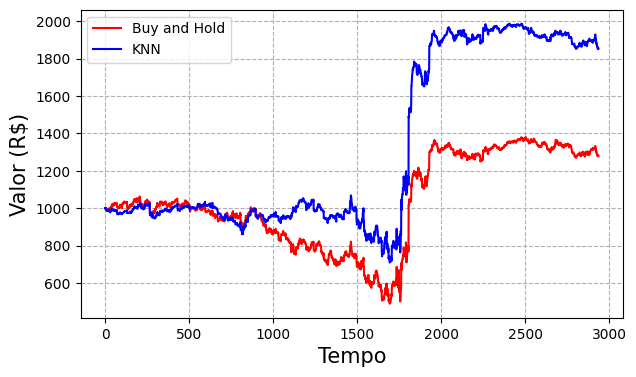

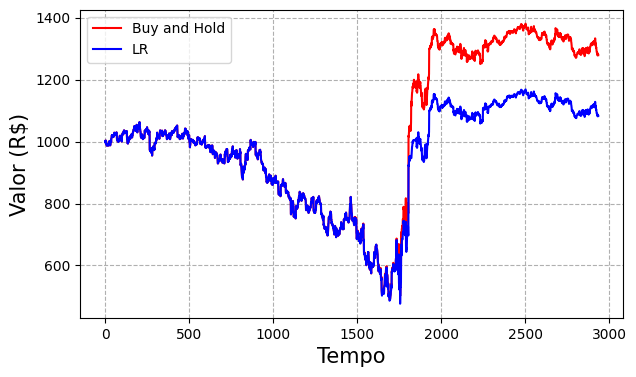

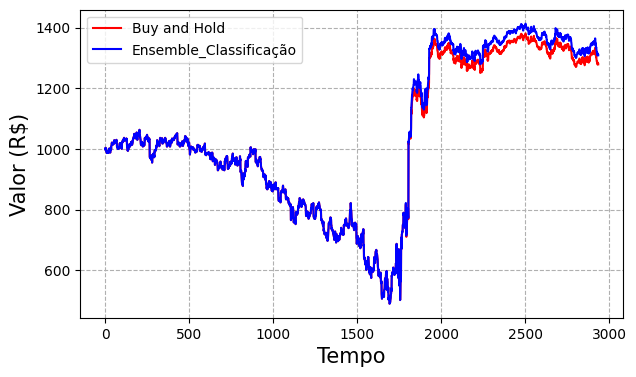

In [10]:
historicAL = []
for i in range(res.shape[1]):
    buyAndHold = 1000;
    modelValue = 1000;

    qtdBH = buyAndHold / Y_testV[0]
    qtdMP = 0
    
    historicBH = []
    historicMP = []
    
    lastprice = Y_testV[0]
    buyingMP = False
    j = 0
        
    for j in range(res.shape[0]):
        if res.iloc[j,i] == 1 and not buyingMP:
            qtdMP      = modelValue/Y_testV[j]
            modelValue = 0;
            buyingMP   = True

        if res.iloc[j,i] == 0 and buyingMP:
            modelValue = qtdMP * Y_testV[j]
            qtdMP      = 0
            buyingMP   = False
        
        historicBH.append(qtdBH * Y_testV[j])
        historicMP.append(max(modelValue, qtdMP * Y_testV[j]))
        
    if buyingMP:
        historicMP[-1] = (qtdMP*Y_testV[j])
    
    historicAL.append(historicMP)
    fig, ax = plt.subplots(figsize=(7,4))
    x = range(res.shape[0])
    ax.plot(x, historicBH, color='r', linestyle='-', label='Buy and Hold')
    ax.plot(x, historicMP, color='b', linestyle='-', label=namesM[i])

    ax.set_xlabel('Tempo',      size=15)
    ax.set_ylabel('Valor (R$)', size=15)
    
    plt.grid(True, linestyle='--')
    plt.legend()

    fig.savefig(f'analysis/{namesM[i]}_comparasion.png')
    plt.show(True)
            

(2936, 4)
4
SVM  -> Valor:  1278.9415656008819   |  %BY:  100.0
KNN  -> Valor:  1852.3674481177125   |  %BY:  144.83597202092804
LR  -> Valor:  1082.3595765024395   |  %BY:  84.62932205928558
Ensemble_Classificação  -> Valor:  1308.7908131654747   |  %BY:  102.33390237423153
1278.9415656008819


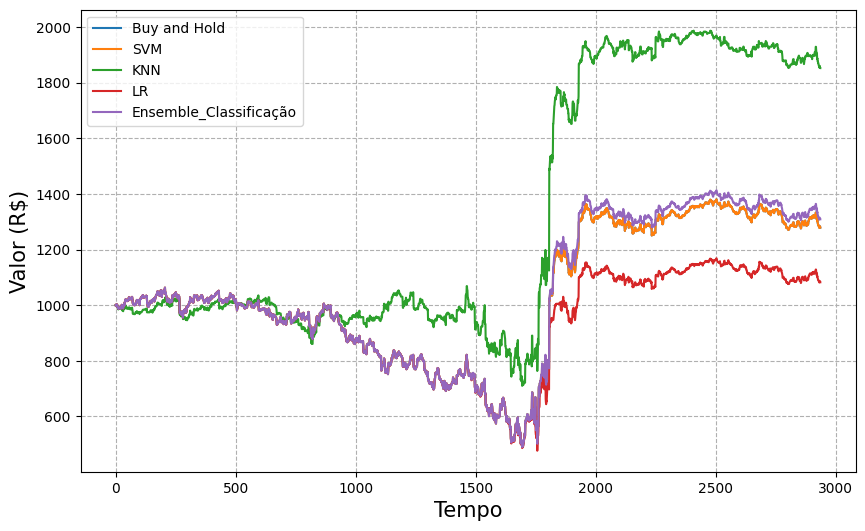

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, historicBH, linestyle='-', label='Buy and Hold')

print(res.shape)
print(len(historicAL))

for i in range(res.shape[1]):
    
    x = range(res.shape[0])
    
    ax.plot(x, historicAL[i], linestyle='-', label=namesM[i])
    print(namesM[i]," -> Valor: ", historicAL[i][-1], "  |  %BY: ",(historicAL[i][-1]*100)/historicBH[-1])
    ax.set_xlabel('Tempo',      size=15)
    ax.set_ylabel('Valor (R$)', size=15)
    

print(historicBH[-1])
plt.grid(True, linestyle='--')
plt.legend()
plt.show(True)
fig.savefig(f'analysis/all_comparasion.png')